# The simple 2-bin demo w/ sigmoid activation

> 

![](assets/training.gif)

In [ ]:
import jax
import neos.makers as makers
import neos.cls as cls
import numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import jax.random
import time

### Initialise network using `jax.experimental.stax`

In [ ]:
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(5),
    stax.Softmax,
)

### Initialse tools from `neos`:

The way we initialise in `neos` is to define functions that make a statistical model from histograms, which in turn are themselves made from a predictive model, such as a neural network. Here's some detail on the unctions used below:

- `hists_from_nn_three_blobs(predict)` uses the nn decision function `predict` defined in the cell above to form histograms from signal and background data, all drawn from multivariate normal distributions with different means. Two background distributions are sampled from, which is meant to mimic the situation in particle physics where one has a 'nominal' prediction for a nuisance parameter and then an alternate value (e.g. from varying up/down by one standard deviation), which then modifies the background pdf. Here, we take that effect to be a shift of the mean of the distribution. The value for the background histogram is then the mean of the resulting counts of the two modes, and the uncertainty can be quantified through the count standard deviation.
- `nn_hepdata_like(hmaker)` uses `hmaker` to construct histograms, then feeds them into the `neos.models.hepdata_like` function that constructs a pyhf-like model. This can then be used to call things like `logpdf` and `expected_data` downstream.
- `cls_maker` takes a model-making function as it's primary argument, which is fed into functions from `neos.fit` that minimise the `logpdf` of the model in both a constrained (fixed parameter of interest) and a global way. Moreover, these fits are wrapped in a function that allows us to calculate gradients through the fits using *fixed-point differentiation*. This allows for the calculation of both the profile likelihood and its gradient, and then the same for $\mathsf{cl_s}$ :)

All three of these methods return functions. in particular, `cls_maker` returns a function that differentiably calculates $\mathsf{cl_s}$ values, which is our desired objective to minimise.

In [ ]:
hmaker = makers.hists_from_nn_three_blobs(predict)
nnm = makers.nn_hepdata_like(hmaker)
loss = cls.cls_maker(nnm, solver_kwargs=dict(pdf_transform=True))

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [ ]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

loss(network,1.)

DeviceArray(0.06006107, dtype=float64)

### Define training loop!

In [ ]:
#jit_loss = jax.jit(loss)

opt_init, opt_update, opt_params = optimizers.adam(1e-3)

#@jax.jit
def update_and_value(i, opt_state, mu):
    net = opt_params(opt_state)
    value, grad = jax.value_and_grad(loss)(net, mu)
    return opt_update(i, grad, state), value, net

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []
    
    # parameter update function
    #@jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net
    
    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i,state,1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [ ]:
def plot(axarr, network, metrics, hm, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = np.linspace(0, 1, 21)
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        levels=levels,
        cmap="BrBG",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        colors="w",
        levels=levels,
    )
    ax.scatter(hm.sig[:, 0], hm.sig[:, 1], alpha=0.25, c="C9", label="sig")
    ax.scatter(hm.bkg1[:, 0], hm.bkg1[:, 1], alpha=0.17, c="C1", label="bkg1")
    ax.scatter(hm.bkg2[:, 0], hm.bkg2[:, 1], alpha=0.17, c="C1", label="bkg2")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    s, b, db = hm(network)
    ax.bar([0, 1], b, color="C1", label="bkg")
    ax.bar([0, 1], s, bottom=b, color="C9", label="sig")
    ax.bar([0, 1], db, bottom=b - db / 2.0, alpha=0.4, color="black", label="bkg error")
    ax.set_ylim(0, 100)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

### Let's run it!!

epoch 0: CLs = 0.0669196913402792, took 4.881189823150635s
epoch 1: CLs = 0.4841473337607056, took 1.4161441326141357s
epoch 2: CLs = 0.32680532475501645, took 1.4054231643676758s
epoch 3: CLs = 0.1699968874285509, took 1.4557290077209473s
epoch 4: CLs = 0.08482955937838588, took 1.42793607711792s
epoch 5: CLs = 0.04455252530370135, took 1.4426677227020264s
epoch 6: CLs = 0.02509858952860622, took 1.3971951007843018s
epoch 7: CLs = 0.015171918468489975, took 1.3903610706329346s
epoch 8: CLs = 0.009819660207323277, took 1.44907808303833s
epoch 9: CLs = 0.0068158194365592895, took 1.4250729084014893s
epoch 10: CLs = 0.005073459554749471, took 1.418778896331787s
epoch 11: CLs = 0.004014875415832453, took 1.4365489482879639s
epoch 12: CLs = 0.0033303831092827973, took 1.4521620273590088s
epoch 13: CLs = 0.002855594445106968, took 1.4769341945648193s
epoch 14: CLs = 0.002504164311135426, took 1.436406135559082s
epoch 15: CLs = 0.002229384440186166, took 1.4946000576019287s
epoch 16: CLs = 0

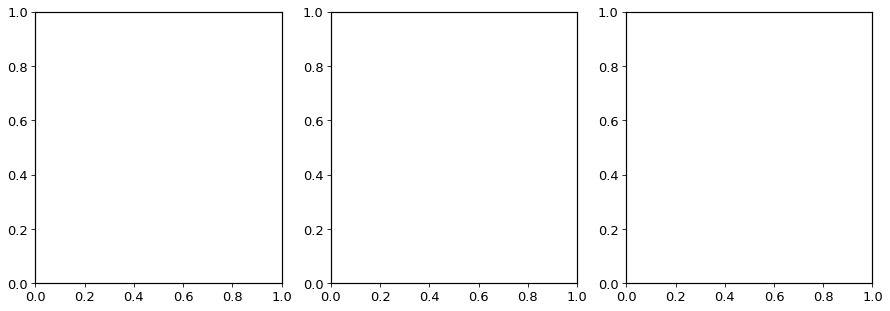

In [ ]:
#slow
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import HTML

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [7.2, 3.0],
        "font.size": 13,
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
camera = Camera(fig)

maxN = 20 # make me bigger for better results!

animate = False # animations fail tests

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, nnm.hm, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        if i % 10 == 0:
            camera.animate().save("animation.gif", writer="imagemagick", fps=8)
            #HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("animation.gif", writer="imagemagick", fps=8)